In [ ]:
%cd ..

In [ ]:
from hft.environment import sampler
import pandas as pd
import glob
import os

In [ ]:
dst_dir = 'notebooks/volume-sampled-8kk'

In [ ]:
if not os.path.exists(dst_dir):
    volume = 8000000
    samplerr = sampler.VolumeSampler('tests/resources/may1/orderbooks/0.csv.gz',
                                   'tests/resources/may1/trades/0.csv.gz',
                                   dst_dir, volume, target_symbol='XBTUSD', nrows=700000, max_workers=8)
    samplerr.split_samples()

In [ ]:
pairs = zip(glob.glob(f'{dst_dir}/orderbook_*'), glob.glob(f'{dst_dir}/trade_*'))

In [ ]:
from hft.backtesting.strategy import CalmStrategy
from hft.backtesting.backtest import BacktestOnSample
from hft.backtesting.readers import OrderbookReader


def init_simulation(orderbook_file, trade_file):
    reader = OrderbookReader(orderbook_file, trade_file, nrows=None, is_precomputed=True)
    strategy = CalmStrategy(initial_balance=0.0)
    backtest = BacktestOnSample(reader, strategy, delay=300)
    backtest.run()

In [ ]:
init_simulation('time-sampled/orderbook_0.csv.gz', 'time-sampled/trade_0.csv.gz')

## Traded volumes

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib.patches as mpatches

In [ ]:
dst_dir = 'time-sampled-10min'

In [ ]:
df = pd.read_csv(f'{dst_dir}/trade_0.csv.gz', header=None, names=['symbol', 'timestamp', 'millis', 'price', 'volume', 't', 'side'])

In [ ]:
xbt_sell = df[(df.symbol == 'XBTUSD') & (df.side == 'Sell')]
xbt_buy = df[(df.symbol == 'XBTUSD') & (df.side == 'Buy') ]

In [ ]:
xbt_sell.volume.sum(), len(xbt_sell)

In [3]:
storage = []

for trade_file in tqdm(glob.glob(f'{dst_dir}/trade_*')):
    df = pd.read_csv(trade_file, header=None, names=['symbol', 'timestamp', 'millis', 'price', 'volume', 't', 'side'])
    xbt = df[df.symbol == 'XBTUSD']
    eth = df[df.symbol == 'ETHUSD']

    xbt_sell = xbt[xbt.side == 'Sell']
    xbt_buy = xbt[xbt.side == 'Buy']
    
    eth_sell = eth[eth.side == 'Sell']
    eth_buy = eth[eth.side == 'Buy']    
    
    values = tuple(map(lambda x: (x.volume.sum(), len(x)), [xbt_sell, xbt_buy, eth_sell, eth_buy]))
    storage.append(values)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2097/2097 [02:19<00:00, 15.02it/s]


In [4]:
storage = np.array(storage).reshape((16776 // 8, 8))

In [5]:
df = pd.DataFrame(storage, columns=['xss', 'xst', 'xbs', 'xbt', 'ess', 'est', 'ebs', 'ebt'])
df['xs'] = df.xss + df.xbs
df['es'] = df.ess + df.ebs

In [6]:
df.describe()

,xss,xst,xbs,xbt,ess,est,ebs,ebt,xs,es
count,2.097000e+03,2097.000000,2.097000e+03,2097.000000,2.097000e+03,2097.000000,2.097000e+03,2097.000000,2.097000e+03,2.097000e+03
mean,1.227437e+07,4356.744397,1.231119e+07,4346.292799,1.128574e+06,639.810205,1.118319e+06,637.723414,2.458557e+07,2.246893e+06
std,1.646719e+07,3669.363232,1.616595e+07,3472.618533,1.715953e+06,645.086826,1.676645e+06,638.289362,3.160311e+07,3.322111e+06
min,0.000000e+00,0.000000,2.300000e+03,4.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,2.300000e+03,0.000000e+00
25%,4.091370e+06,2129.000000,4.157867e+06,2156.000000,2.790530e+05,236.000000,2.962090e+05,236.000000,8.647778e+06,6.326700e+05
50%,7.242018e+06,3239.000000,7.248993e+06,3282.000000,5.501070e+05,408.000000,5.621730e+05,420.000000,1.460722e+07,1.146290e+06
75%,1.354041e+07,5397.000000,1.352636e+07,5285.000000,1.187345e+06,785.000000,1.193955e+06,787.000000,2.744901e+07,2.354260e+06
max,2.818045e+08,44236.000000,2.053930e+08,29386.000000,2.071360e+07,5779.000000,1.620701e+07,4622.000000,4.871975e+08,3.562047e+07


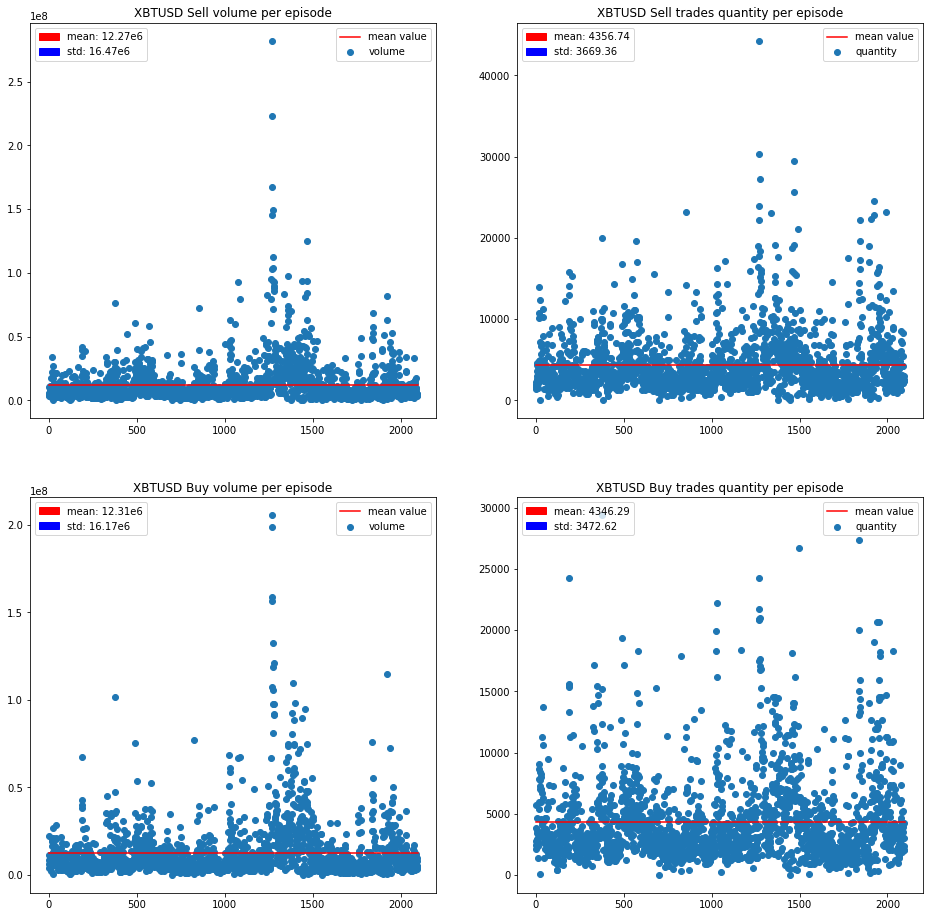

In [7]:
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 2

labels = ['XBTUSD Sell volume per episode', 'XBTUSD Sell trades quantity per episode', 
          'XBTUSD Buy volume per episode', 'XBTUSD Buy trades quantity per episode']
for i, value, title in zip(range(1, columns*rows +1), [df.xss, df.xst, df.xbs, df.xbt], labels):
    
    mean, std = value.mean(), value.std()
    
    if i % 2 != 0:
        mean /= 1e6
        std  /= 1e6
        text  = 'e6'
        label = 'volume'
    else:
        text = ''
        label = 'quantity'
    
    patches = [
        mpatches.Patch(color='red', label=f'mean: {mean:.2f}{text}'),
        mpatches.Patch(color='blue', label=f'std: {std:.2f}{text}')
    ]
    fig.add_subplot(rows, columns, i)
    plt.scatter(range(0, len(value)), value, label=label)
    plt.plot([0, len(value)], [value.mean(), value.mean()], c='red', label='mean value')
    
    main_legend = plt.legend(loc=1)
    plt.legend(handles=patches, loc=2)
    plt.gca().add_artist(main_legend)
    plt.title(title)
    
plt.show()

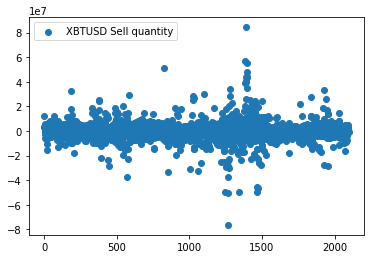

In [8]:
plt.scatter(range(0, len(storage)), df.xbs - df.xss, label='XBTUSD Sell quantity')
plt.legend()